# Notes:
    - When Choosing the Block size it may be helpful to also see with OTSU how the scales are layed out: the dense
    - Could machine learning be could in choosing the best block size?
    - How does Otsu as the method compare for finding the correct counts.

In [97]:
''' Everything is from Tanya's "Cleaned_Up_Blur_Otsu", except for the block of code under the scale images,
which analyzes the results and prints the "overall analysis" section above each image'''

' Everything is from Tanya\'s "Cleaned_Up_Blur_Otsu", except for the block of code under the scale images,\nwhich analyzes the results and prints the "overall analysis" section above each image'

In [2]:
import cv2
import numpy as np
from datascience import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import pandas
import statistics

In [3]:
images = []
labeled_imgs = []
original_img = []
original_img1 = []
filter_img = []
image_names = []

num_scales_and_average_size = []
sizes_of_scales = []
total_stats = []

In [4]:
def invert(img):
    return cv2.bitwise_not(img)

In [5]:
#access img directory
dirname = 'Anolis_cristatellus_images/'


#create an iterator object for img directory
directory = os.scandir(dirname)

#for areas that are unfirform calculate the scale si

#print(os.listdir(dirname))
def threshold(customized):
    index = 0;
    images.clear
    
    if(len(customized) == 0):
        print("THRESHOLDING WITH OTSU INITIALLY")
    #iterates through each image in the directory
    for img in directory:
        img_name = img.name
        if (img_name != '.ipynb_checkpoints' and img_name != '.DS_Store'):

            if(len(customized) == 0):
                image_names.append(img.name)
            
            #read the image, convert to grayscale add to array and title + blur
            img = cv2.imread(dirname + img_name)
            original_img1.append(img)
            #img = invert(img)
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            original_img.append(gray)
            title = img_name
            img = gray
            
            if(len(customized) > 0 and block_size[index][0] > 15):
                blur = cv2.GaussianBlur(img,(5,5),1)
                blur = cv2.bilateralFilter(blur,10,10,100)
            else:
                blur = cv2.GaussianBlur(img,(5,5),0)
                
           
            filter_img.append(blur)
            
            #if the customized block size has not yet been determined this if statement will run
            if(len(customized)==0):
                #print("Initial Value used")
                ret, thresh = cv2.threshold(blur,0 , 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                
            #if customized block size has been determined
            else:
                thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size[index][0], -2)
                
            kernel = np.ones((3,3),np.uint8)
            
            #if the customized iteration number has not yet been determined this if statement will run
            if(len(customized)==0):
                opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)
            
            #if customized array is greater than size 0 iteration number has been determined
            else:
                opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=block_size[index][1])

            
            # sure background area
            sure_bg = cv2.dilate(opening,kernel,iterations=1)

            # Finding sure foreground area: What does cv2.DIST do?
            dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
            ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0) 

            # Finding unknown region
            sure_fg = np.uint8(sure_fg)
            unknown = cv2.subtract(sure_bg,sure_fg)
            
            #adding sure_fg binarization to list of images
            images.append(sure_fg)
            
            
            #plt.subplot(1,3,1), plt.imshow(gray, 'gray')
            #plt.subplot(1,3,2), plt.imshow(sure_fg, 'gray') 
            #plt.show()
        
            # Label and count (taken from maggie's code)
            # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
            count, labels = cv2.connectedComponents(sure_fg)                
            count = count - 1 # background doesn't count as a scale
            label_hue = np.uint8(179 * labels / np.max(labels))
            blank_ch = 255 * np.ones_like(label_hue)
            labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
            labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
            labeled_img[label_hue == 0] = 0
            
            if(len(customized) != 0):
                labeled_imgs.append(labeled_img)
            index += 1
            
print("INITIAL TEST BINARIZATION\n")
threshold([])

INITIAL TEST BINARIZATION

THRESHOLDING WITH OTSU INITIALLY


In [6]:
print(len(images))
#iterates through images to determine average size and count of scales in␣initial binarization
for i in np.arange(len(images)):    
    img = images[i]

    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # or whatever you prefer
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
    num_labels = output[0]
    
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    #print(centroids.shape)
    

    sizes_of_scales.append((stats[1:,-1]))
    num_scales_and_average_size.append(([num_labels, np.average(stats[1:,-1])]))
    total_stats.append([num_labels, stats[1:,-1], stats[1:,-1]])
    
print(len(num_scales_and_average_size))

55
55


In [7]:
block_size = []

#we need a better way of doing this: what's considerd shade and whats considerd not shade: usually big chunks of black
#or white indicate a gradient: the issue is when the chunks are black: considerd background? 
#use uniformity somehow to fix this?
index = 0

print(len(num_scales_and_average_size))
print(len(block_size))


for stat in num_scales_and_average_size:
    if stat[0] <= 3:
        block_size.append([15,1])
    elif stat[1] < 350:
        block_size.append([65, 2])
    elif stat[1] < 550:
        block_size.append([65, 3])
    else:
        block_size.append([85, 1])
    index +=1
        
print("BS", len(block_size))
print("Im", len(images))
#size_and_iter = Table().with_columns("size", num_scales_and_average_size, "img_name", image_names, "block_size", [i[0]for i in block_size], "iterations" ,[i[1] for i in block_size])
#size_and_iter.show()

55
0
BS 55
Im 55


In [8]:
dirname = 'Anolis_cristatellus_images/'
#create an iterator object for img directory
directory = os.scandir(dirname)
images = []
threshold(block_size)



In [9]:
all_scale_counts = [i[0] for i in total_stats]
all_sizes = [i[1] for i in total_stats]
#sorts all_sizes so that the sizes of the scales are arranged from largest to␣smallest in array
for array_index in np.arange(len(all_sizes) - 1):
    all_sizes[array_index].sort()
    all_sizes[array_index] = all_sizes[array_index][::-1]
    averages = []
for size_array in all_sizes:
    num_nums = (np.rint(len(size_array)/2)).astype(int)
    averages = np.append(averages, np.average(size_array[0:num_nums]))

In [10]:
def overlay(bw_img, color_mask, w1=0.2, w2=0.95):
    a = cv2.cvtColor(bw_img, cv2.COLOR_GRAY2RGB)
    a -= np.min(a)
    a = a/np.max(a)*255
    a = np.clip(a, a_min=0, a_max=255).astype(int)
    b = np.clip(color_mask, a_min=0, a_max=255).astype(int)
    c = cv2.addWeighted(b,w1,a,w2,0)
    return c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRYING TO CLEAN UP THE IMAGES AND REMOVE SMALL SPECKELS: SHOULD TAKE INTO ACCOUNT DISTANCE AND SIZE
65
Std dev for scale area: 16.673332000533065
(Std dev / mean) for scale area: 0.15054927314251074
Avg bounding box overlap: 0.4518313327177593
Avg fullness: 0.7233660130718954

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


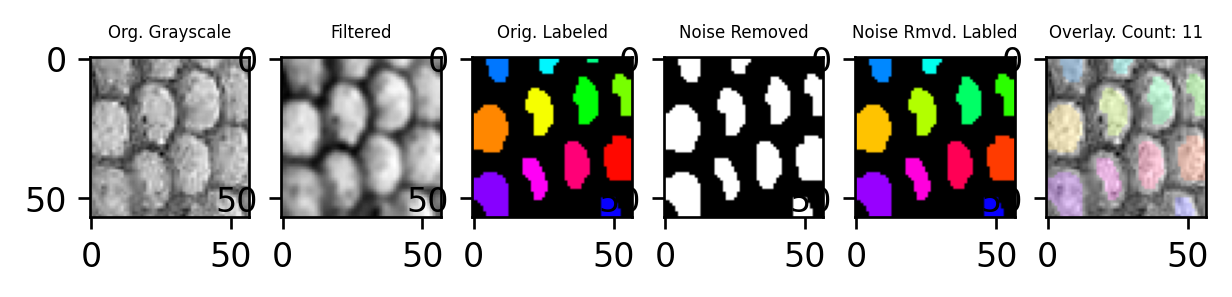

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 6.082762530298219
(Std dev / mean) for scale area: 0.7040234410067383
Avg bounding box overlap: 0.16727272727272727
Avg fullness: 0.6424126984126985

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


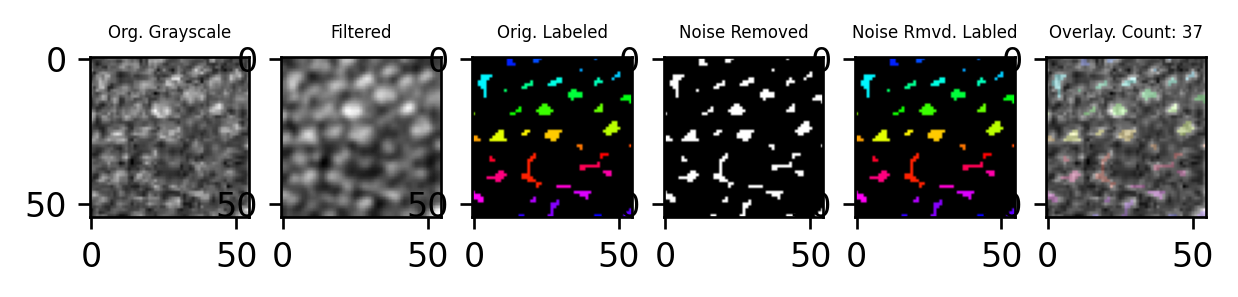

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 0.4894578313253012
Avg fullness: 0.45808531746031744

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: True
Scales shapes are full, not web-like: False


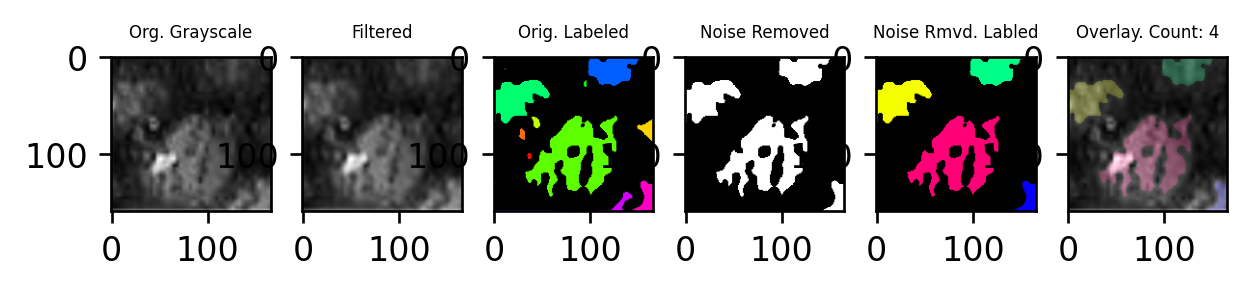

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 0.6187307369010927
Avg fullness: 0.49039849039849037

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: True
Scales shapes are full, not web-like: False


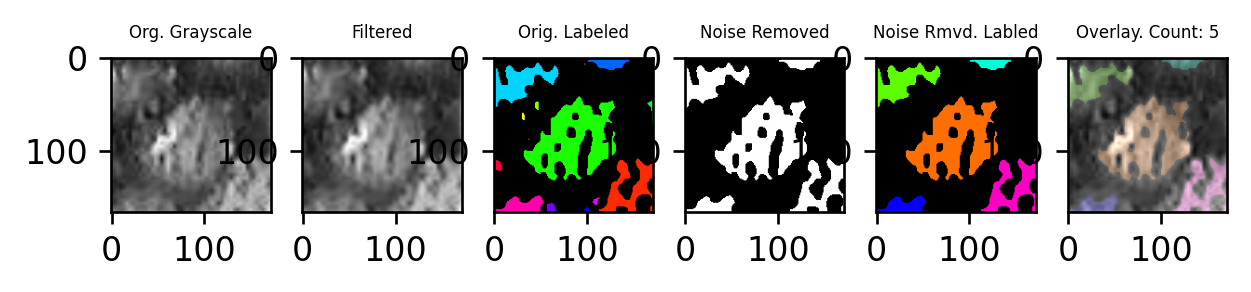

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 3.872983346207417
(Std dev / mean) for scale area: 0.7701955518026113
Avg bounding box overlap: 0.1653198653198653
Avg fullness: 0.7275992063492062

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


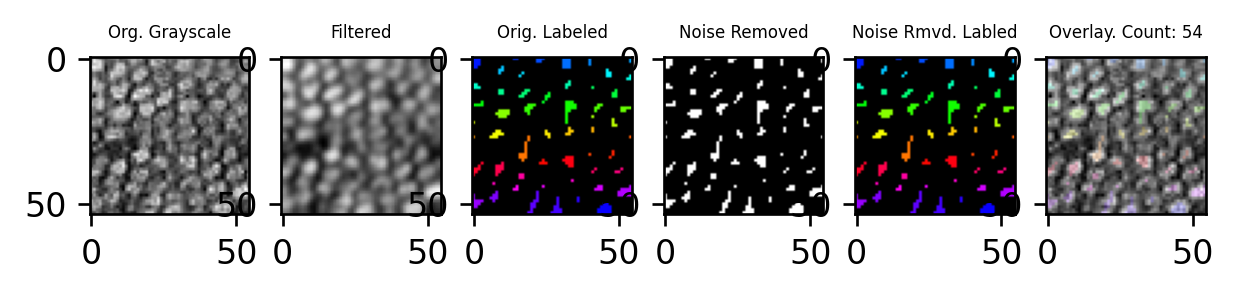

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 4.0
(Std dev / mean) for scale area: 0.7960199004975124
Avg bounding box overlap: 0.13950413223140495
Avg fullness: 0.8139583333333332

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


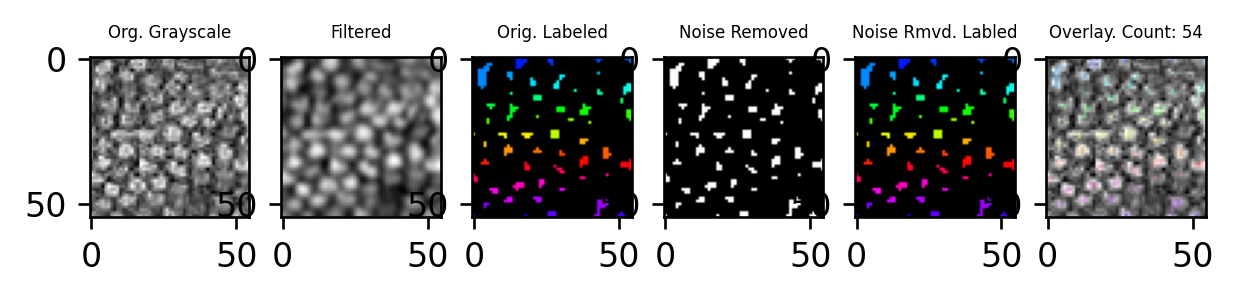

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 5.830951894845301
(Std dev / mean) for scale area: 1.0783267202796103
Avg bounding box overlap: 0.21986531986531987
Avg fullness: 0.8081481481481482

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: False
Scales are localized: True
Scales shapes are full, not web-like: True


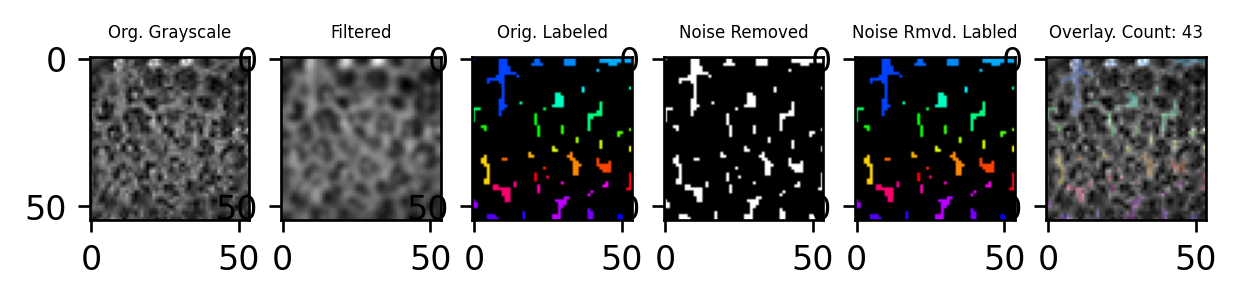

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Std dev for scale area: 643.4671708797582
(Std dev / mean) for scale area: 0.2307160885190958
Avg bounding box overlap: 0.6408045977011494
Avg fullness: 0.5230261012958844

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: False
Scales shapes are full, not web-like: False


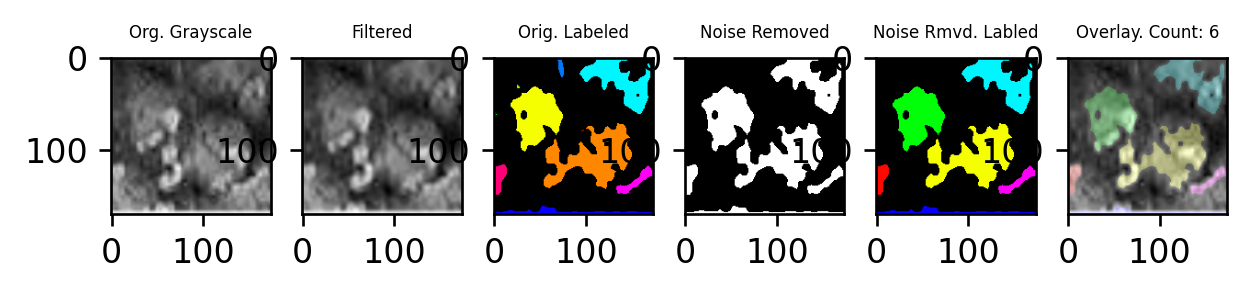

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Std dev for scale area: 1129.970353593403
(Std dev / mean) for scale area: 1.0504023737795984
Avg bounding box overlap: 0.6072950337937114
Avg fullness: 0.5438292169224372

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: False
Scales are localized: True
Scales shapes are full, not web-like: False


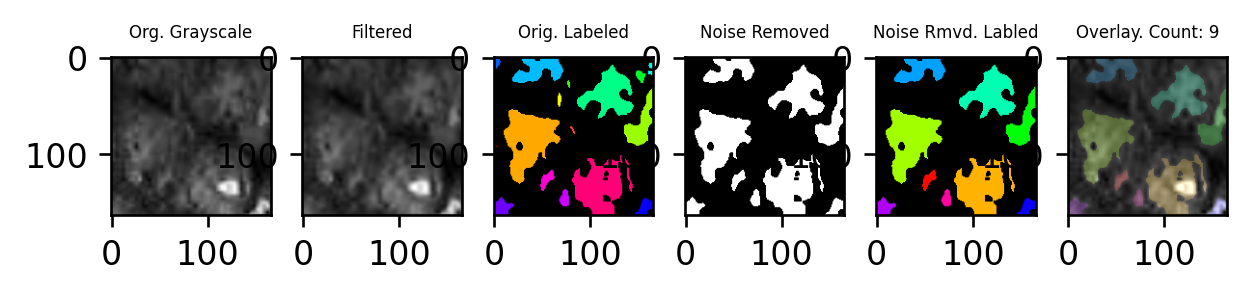

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 9.591663046625438
(Std dev / mean) for scale area: 1.265904767574931
Avg bounding box overlap: 0.16964285714285715
Avg fullness: 0.7726228632478632

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: False
Scales are localized: True
Scales shapes are full, not web-like: True


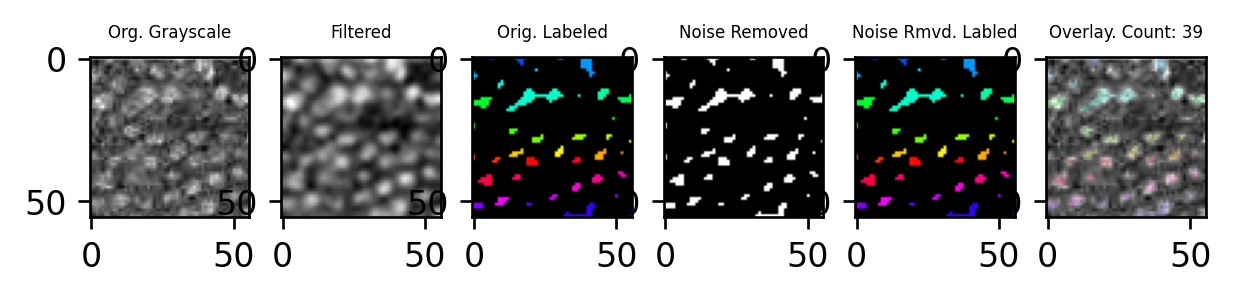

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 20.952326839756964
(Std dev / mean) for scale area: 0.25396759805766017
Avg bounding box overlap: 0.45451843043995244
Avg fullness: 0.7183551198257081

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


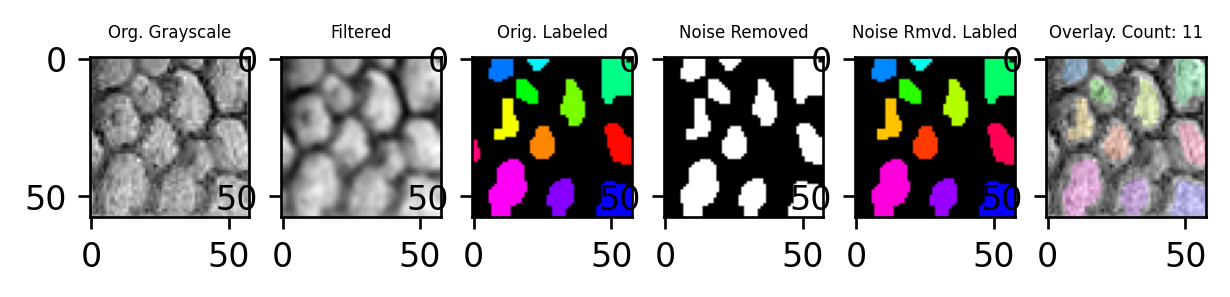

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 7.0710678118654755
(Std dev / mean) for scale area: 1.359820733051053
Avg bounding box overlap: 0.15669421487603305
Avg fullness: 0.7827407407407407

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: False
Scales are localized: True
Scales shapes are full, not web-like: True


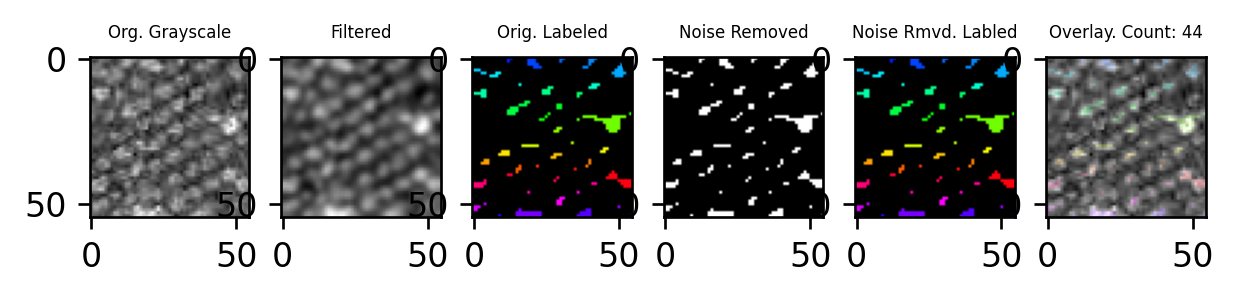

85
Std dev for scale area: 1656.75103742234
(Std dev / mean) for scale area: 0.8021065298583103
Avg bounding box overlap: 0.44164513350559864
Avg fullness: 0.4015863689776733

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


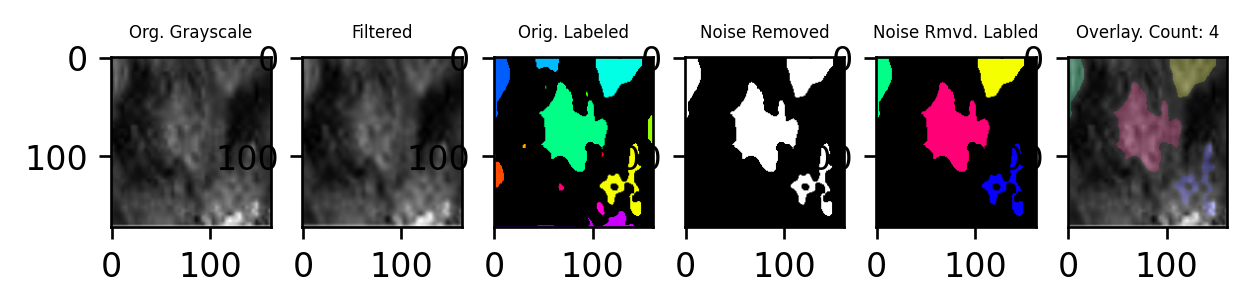

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 7.874007874011811
(Std dev / mean) for scale area: 0.9842509842514764
Avg bounding box overlap: 0.22115702479338842
Avg fullness: 0.6576265799529689

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


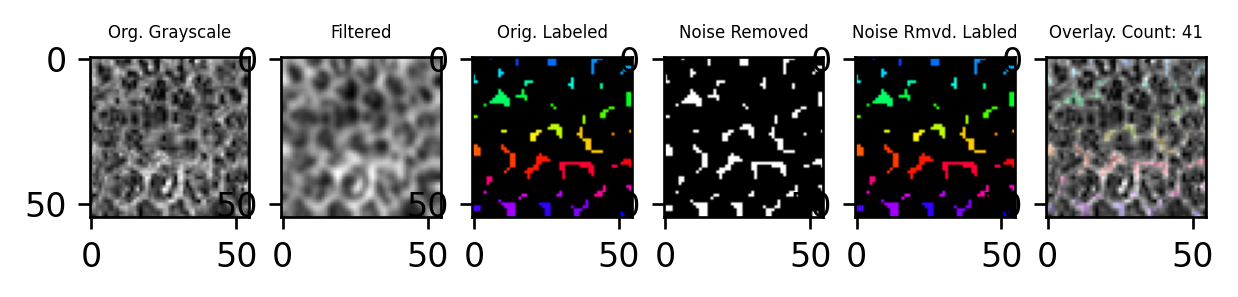

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 4.69041575982343
(Std dev / mean) for scale area: 0.7304745855462718
Avg bounding box overlap: 0.1734006734006734
Avg fullness: 0.7056798245614034

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


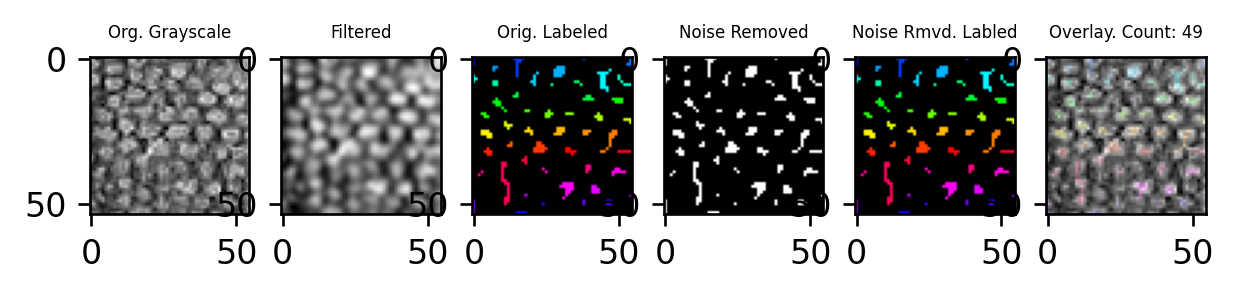

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 5.385164807134504
(Std dev / mean) for scale area: 1.0224996469242729
Avg bounding box overlap: 0.14074074074074075
Avg fullness: 0.7789586339586341

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: False
Scales are localized: True
Scales shapes are full, not web-like: True


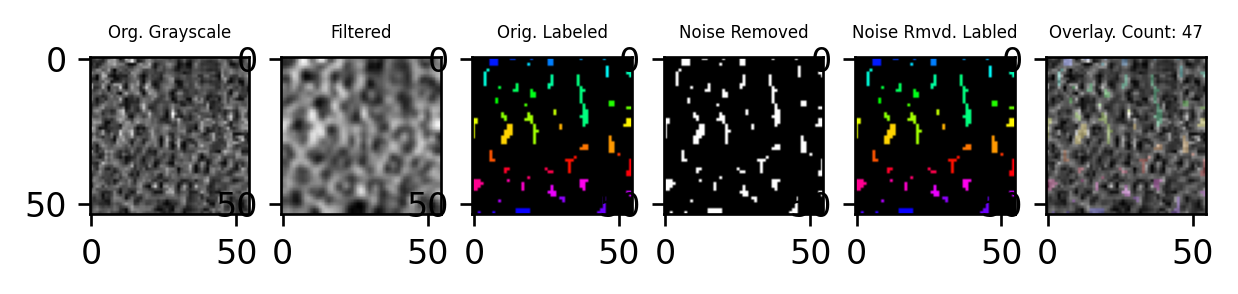

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 1.0619820903501738

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: Cannot determine because all scales are edge-scales


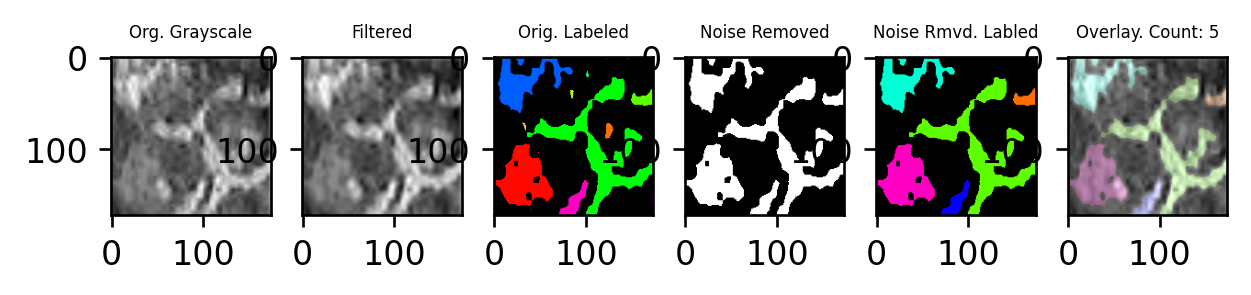

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Avg bounding box overlap: 0.7716220375500153
Avg fullness: 0.45294117647058824

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: False


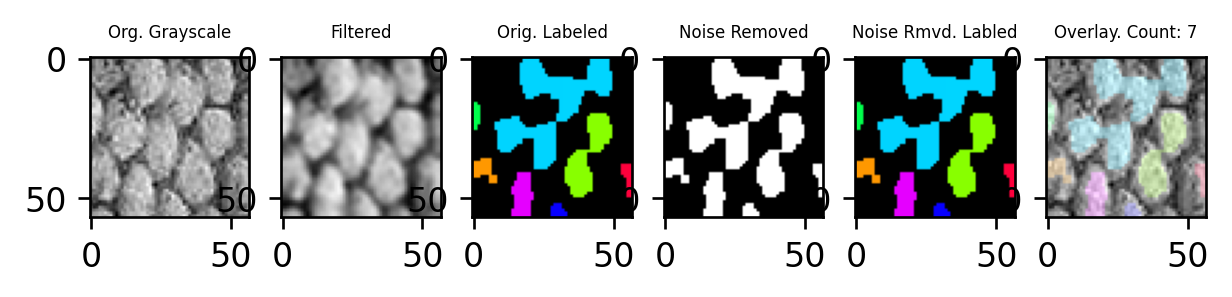

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 399.0739279882864
(Std dev / mean) for scale area: 1.0966582247548404
Avg bounding box overlap: 0.513657876943881
Avg fullness: 0.5874108583743118

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: False
Scales are localized: True
Scales shapes are full, not web-like: False


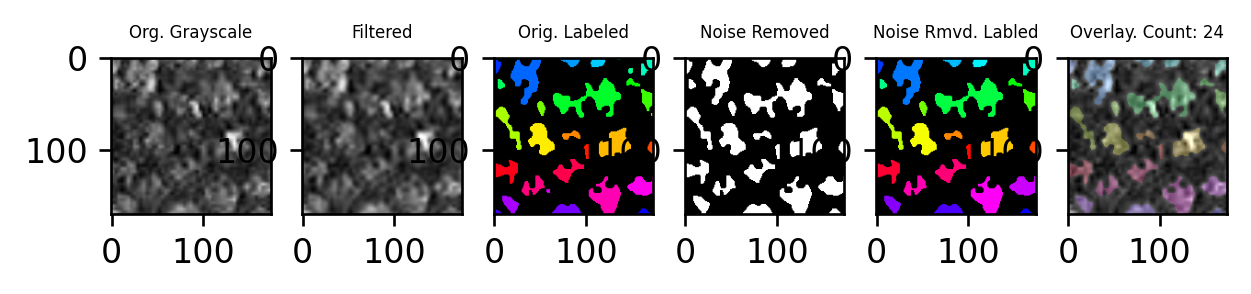

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 264.95848731452253
(Std dev / mean) for scale area: 0.5892331074451946
Avg bounding box overlap: 0.4355211543849818
Avg fullness: 0.5966786319630871

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


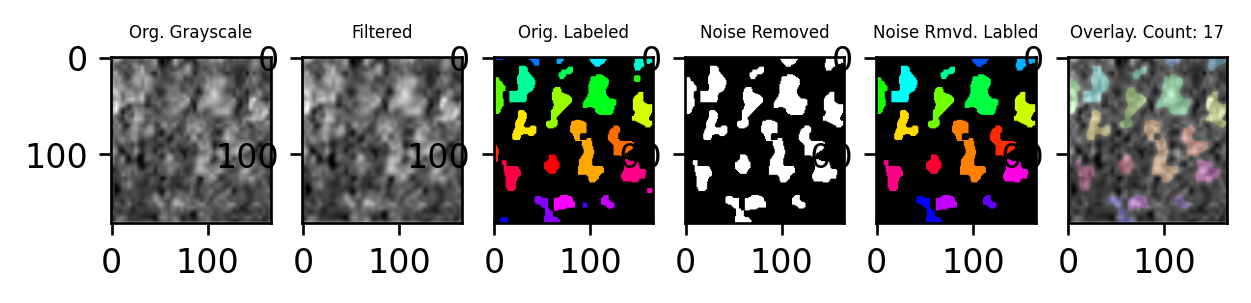

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 191.50718002205556
(Std dev / mean) for scale area: 0.5745215400661667
Avg bounding box overlap: 0.41787782110362753
Avg fullness: 0.6460129753162522

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


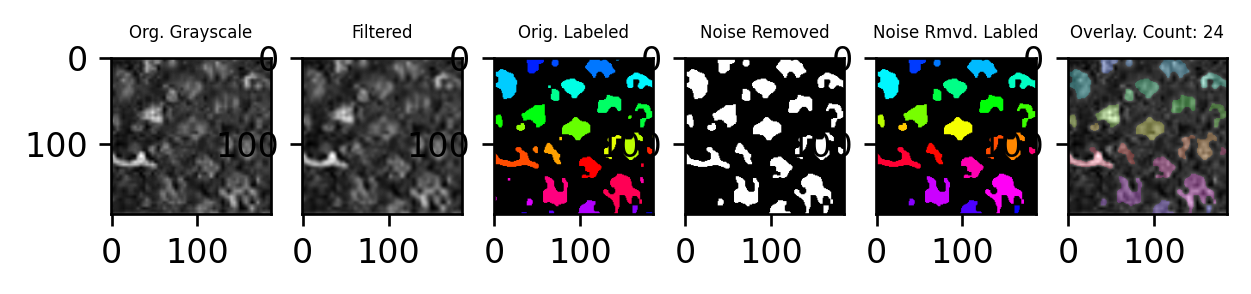

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 294.38240436547835
(Std dev / mean) for scale area: 0.6665621318319095
Avg bounding box overlap: 0.4761541279921837
Avg fullness: 0.5804434853970049

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


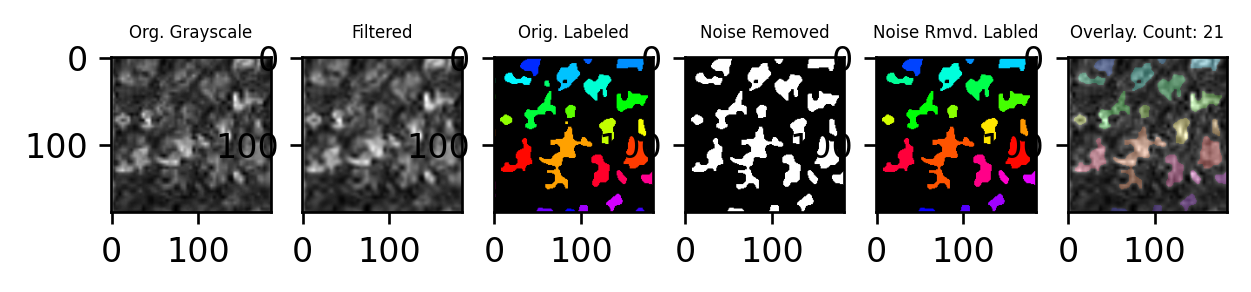

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 166.0752841334315
(Std dev / mean) for scale area: 0.48489134053556643
Avg bounding box overlap: 0.44837595532039975
Avg fullness: 0.5227727512098437

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


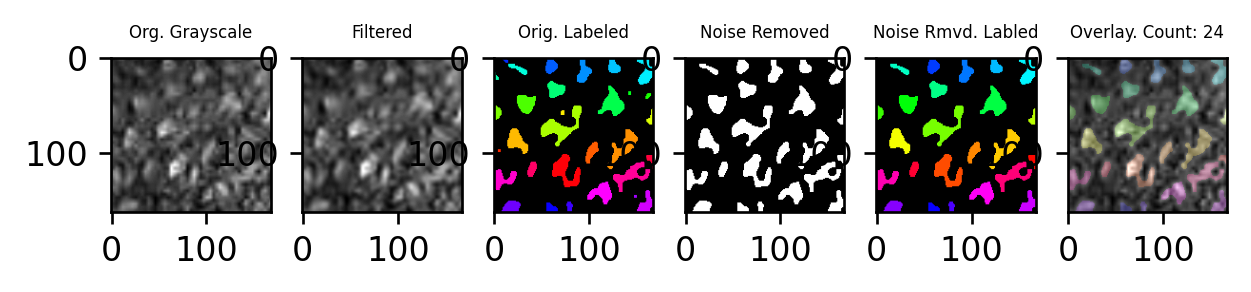

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 199.14065381031568
(Std dev / mean) for scale area: 0.500604961815776
Avg bounding box overlap: 0.3876989439238435
Avg fullness: 0.6373825607955951

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


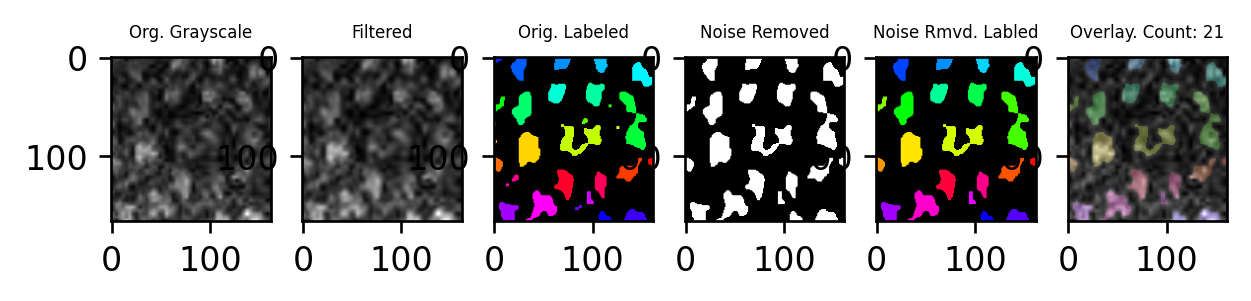

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 6.708203932499369
(Std dev / mean) for scale area: 1.118033988749895
Avg bounding box overlap: 0.1549346879535559
Avg fullness: 0.7042692473814922

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: False
Scales are localized: True
Scales shapes are full, not web-like: True


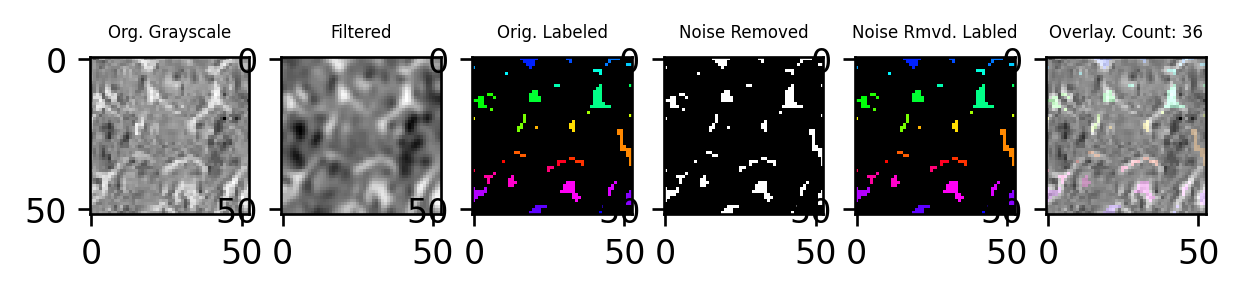

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 114.45086281894078
(Std dev / mean) for scale area: 0.6471373503494228
Avg bounding box overlap: 0.3211298377028714
Avg fullness: 0.6710168795238228

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


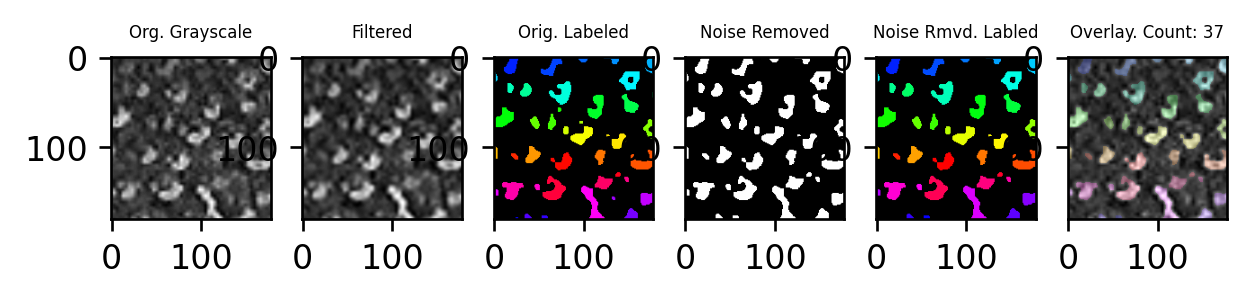

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 59.27900134111572
(Std dev / mean) for scale area: 0.512794129248406
Avg bounding box overlap: 0.4050925925925926
Avg fullness: 0.7845354645354645

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


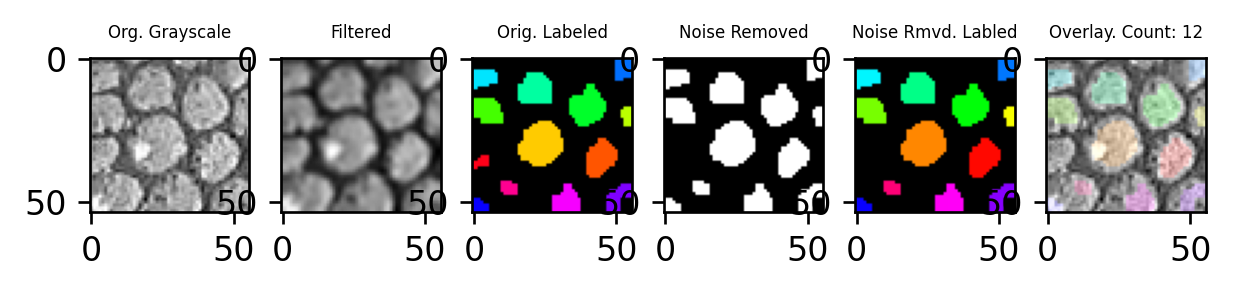

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 153.32318807016765
(Std dev / mean) for scale area: 0.7098295743989242
Avg bounding box overlap: 0.3588201272411799
Avg fullness: 0.5720054074316802

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


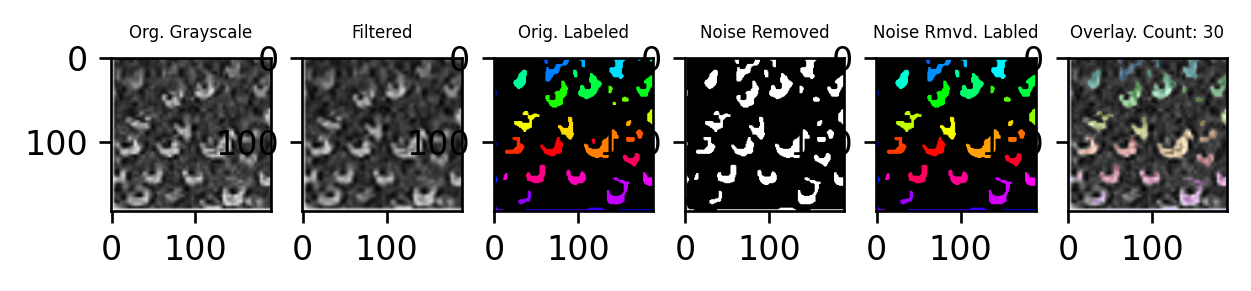

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 204.02695900297098
(Std dev / mean) for scale area: 0.6045243229717658
Avg bounding box overlap: 0.4718018018018018
Avg fullness: 0.6000089935865958

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


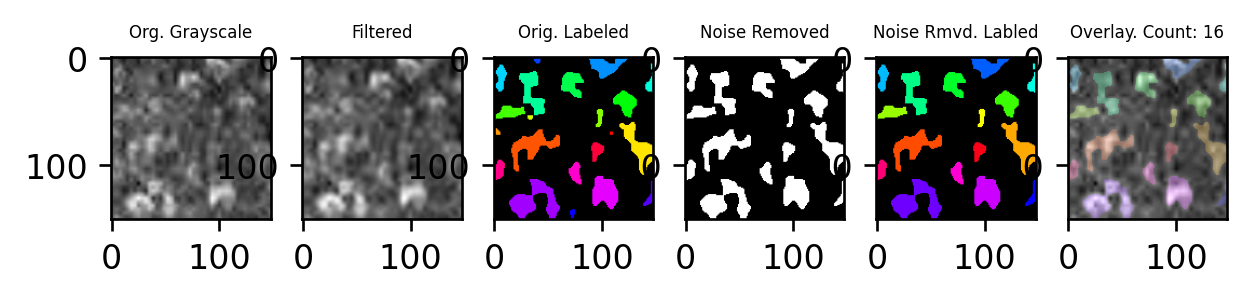

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 13.820274961085254
(Std dev / mean) for scale area: 0.4041016070492764
Avg bounding box overlap: 0.2487012987012987
Avg fullness: 0.45473544973544977

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


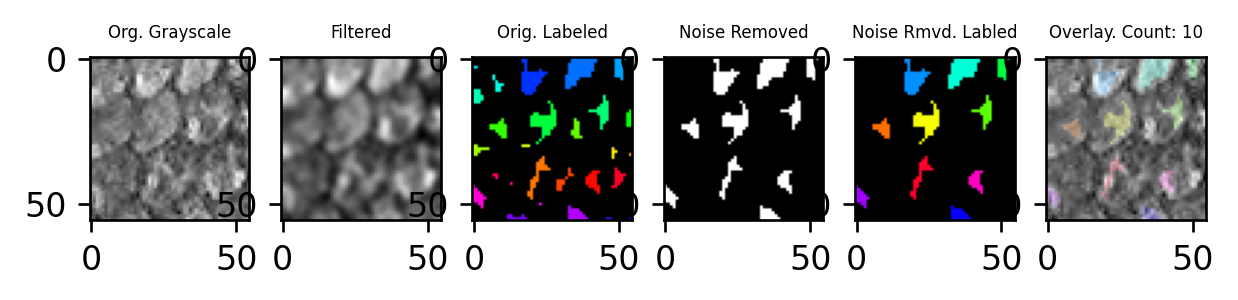

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 24.269322199023193
(Std dev / mean) for scale area: 1.3158066252482454
Avg bounding box overlap: 0.3494194484760523
Avg fullness: 0.6121889425657541

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: False
Scales are localized: True
Scales shapes are full, not web-like: False


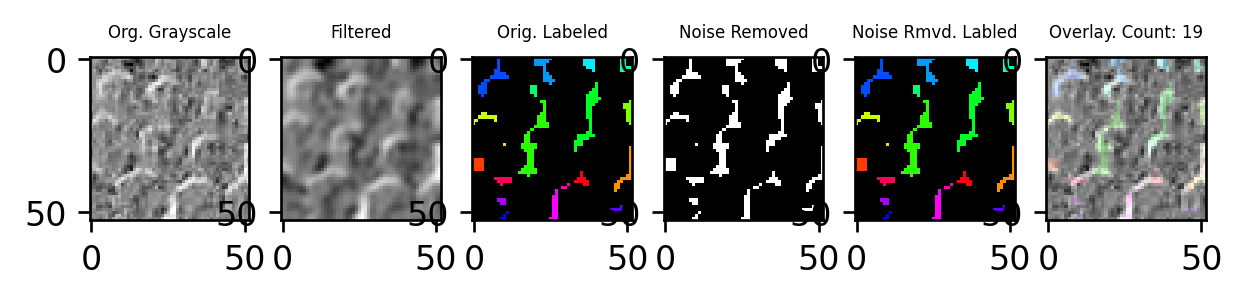

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 27.694764848252458
(Std dev / mean) for scale area: 0.3573518044935801
Avg bounding box overlap: 0.30096793708408953
Avg fullness: 0.7847188305521638

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


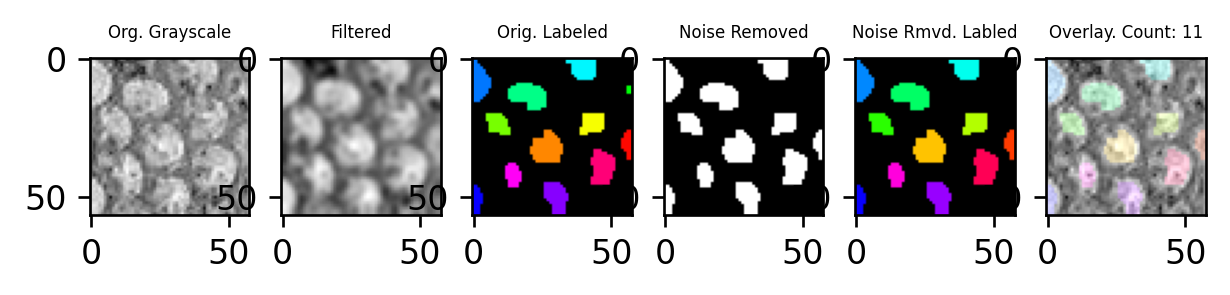

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 163.90851106638726
(Std dev / mean) for scale area: 0.4420667065020933
Avg bounding box overlap: 0.4528273129096174
Avg fullness: 0.5991193966191405

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


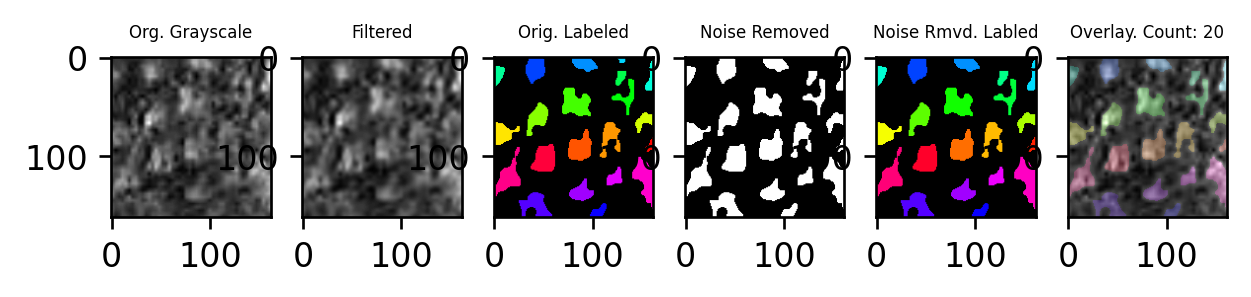

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 497.70674096298916
(Std dev / mean) for scale area: 0.6969055882795648
Avg bounding box overlap: 0.4320236725300016
Avg fullness: 0.6114540865468866

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


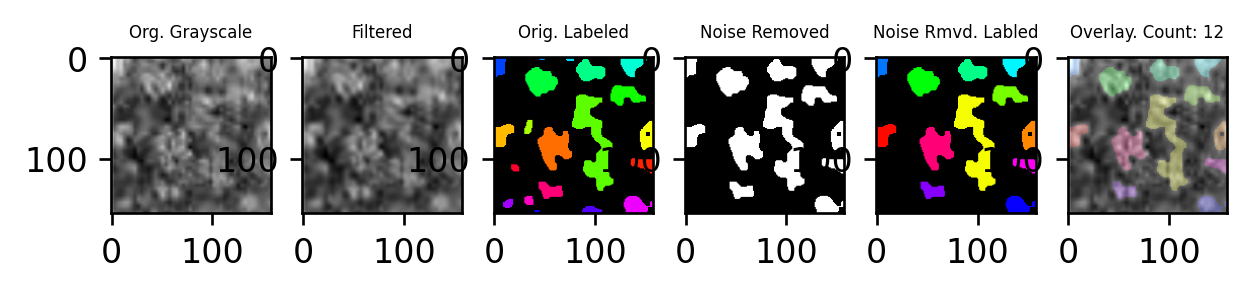

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 275.0872588834314
(Std dev / mean) for scale area: 0.6699389969060712
Avg bounding box overlap: 0.44161692892023874
Avg fullness: 0.5864377190647942

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


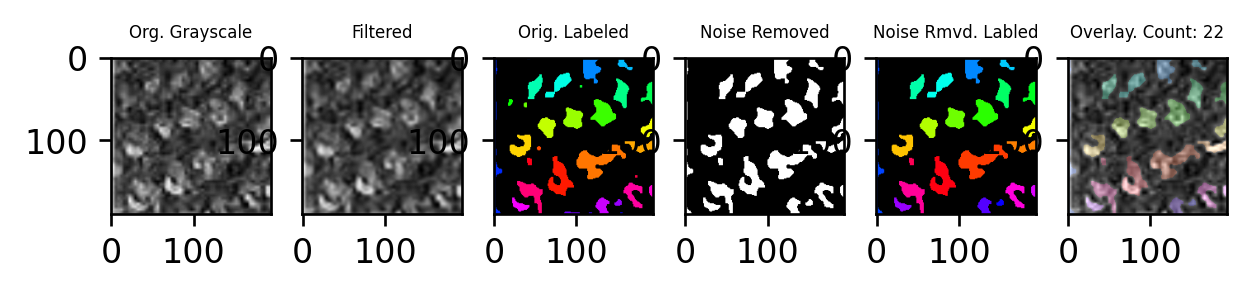

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 48.13522618623496
(Std dev / mean) for scale area: 0.5175830772713437
Avg bounding box overlap: 0.38776859504132233
Avg fullness: 0.6537037037037037

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


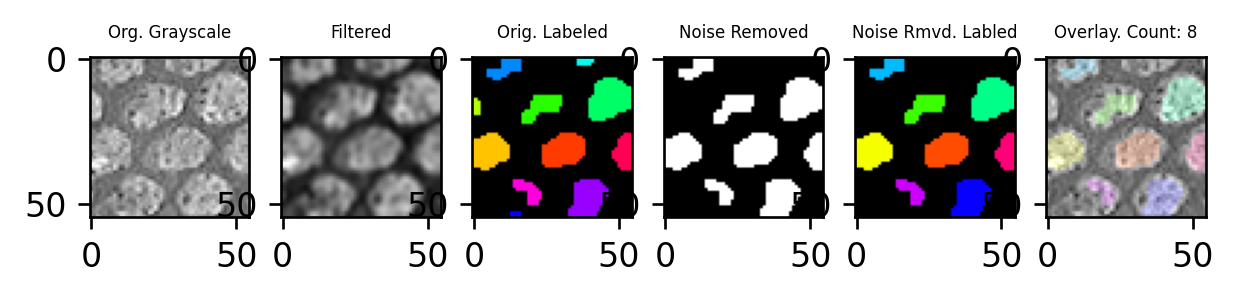

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 54.699177324709375
(Std dev / mean) for scale area: 0.7012715041629407
Avg bounding box overlap: 0.2779220779220779
Avg fullness: 0.7465560583207642

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


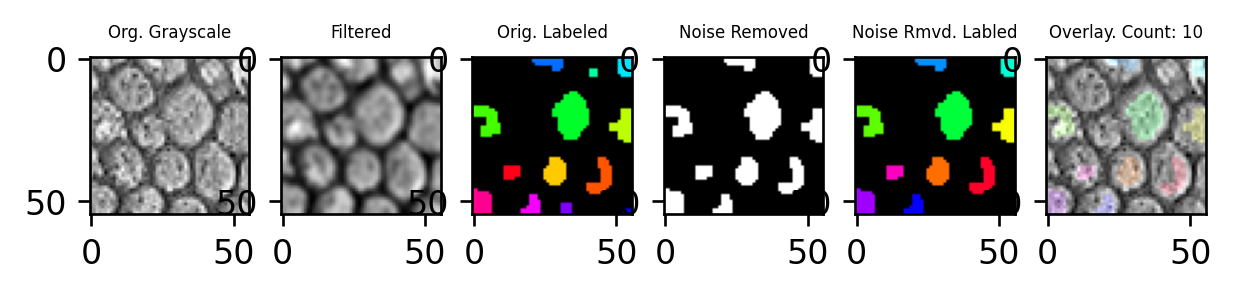

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 188.04786624686813
(Std dev / mean) for scale area: 0.6273490116659487
Avg bounding box overlap: 0.4723557692307692
Avg fullness: 0.4773711318984405

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


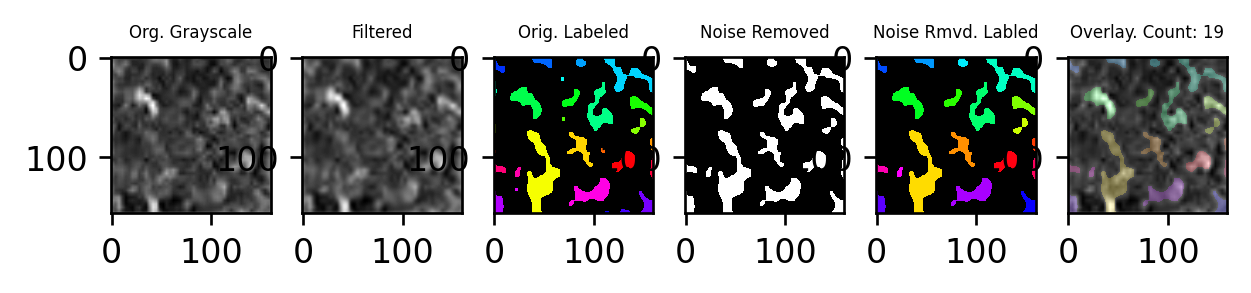

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 44.609416046390926
(Std dev / mean) for scale area: 0.4067727906965738
Avg bounding box overlap: 0.3457350272232305
Avg fullness: 0.6785523504273504

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


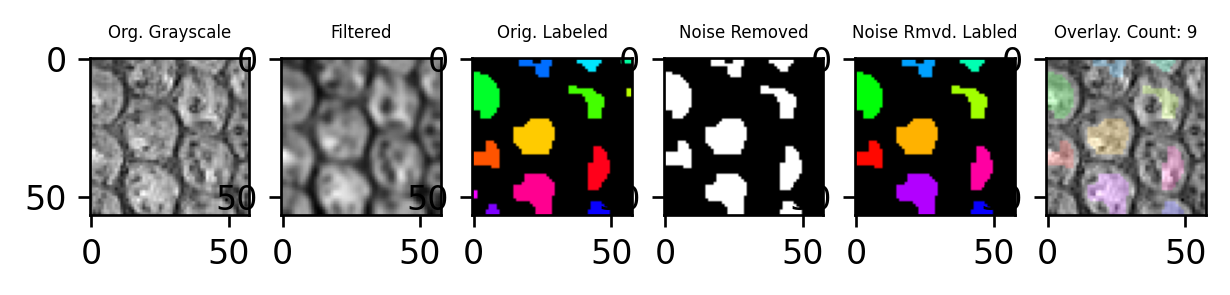

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Avg bounding box overlap: 0.7455621301775148
Avg fullness: 0.3541666666666667

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: False


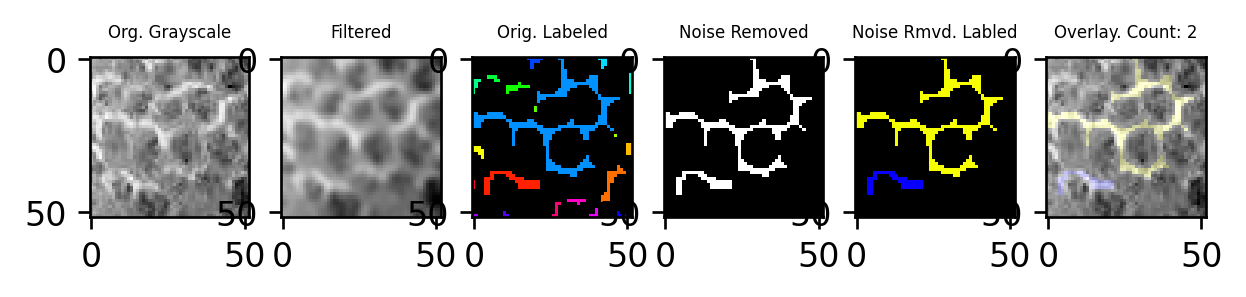

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 0.8263888888888888

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: Cannot determine because all scales are edge-scales


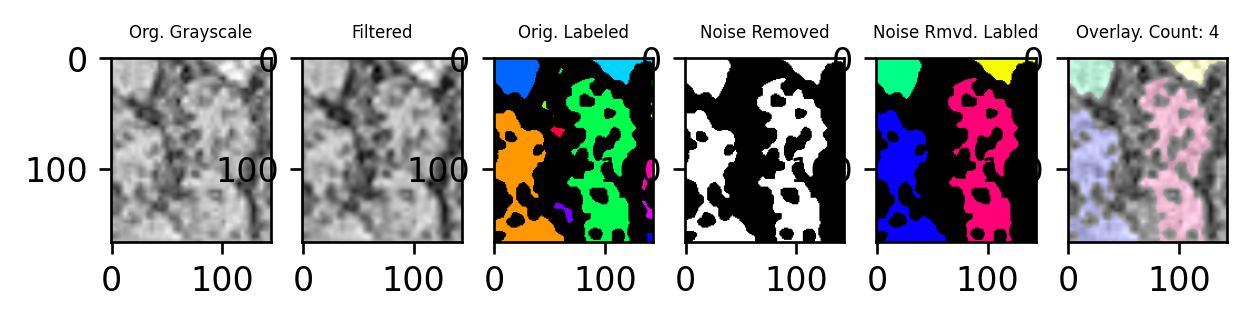

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 2.6457513110645907
(Std dev / mean) for scale area: 0.5691441773801736
Avg bounding box overlap: 0.13527945888216447
Avg fullness: 0.7755255255255258

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


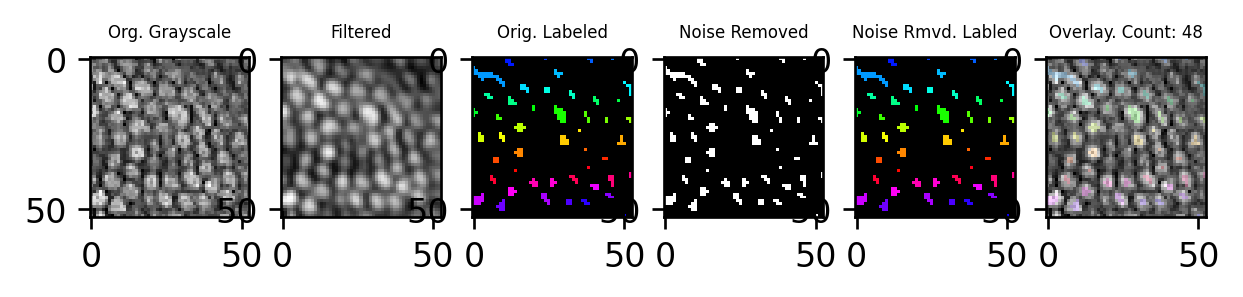

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 3.605551275463989
(Std dev / mean) for scale area: 0.633169980081481
Avg bounding box overlap: 0.15164220824598182
Avg fullness: 0.754706790123457

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


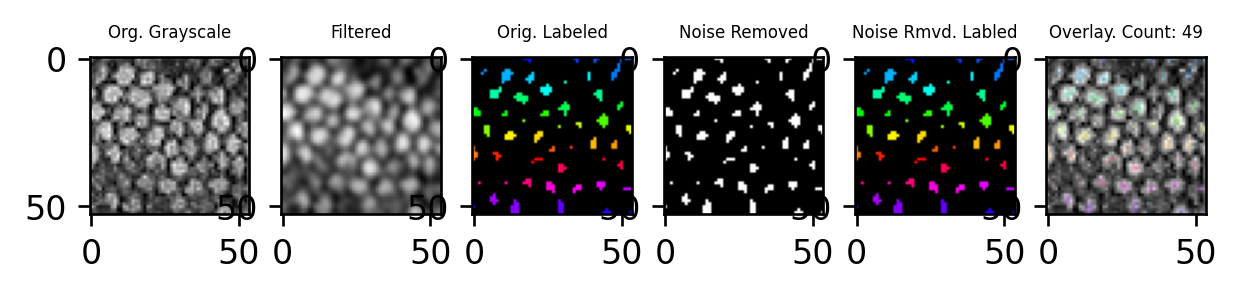

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 1.1386242644998599

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: Cannot determine because all scales are edge-scales


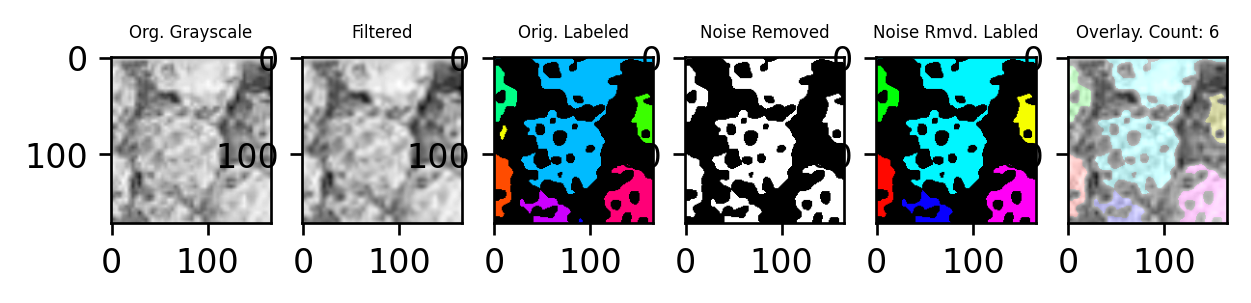

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 3.1622776601683795
(Std dev / mean) for scale area: 0.5270462766947299
Avg bounding box overlap: 0.14046121593291405
Avg fullness: 0.756831831831832

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: True


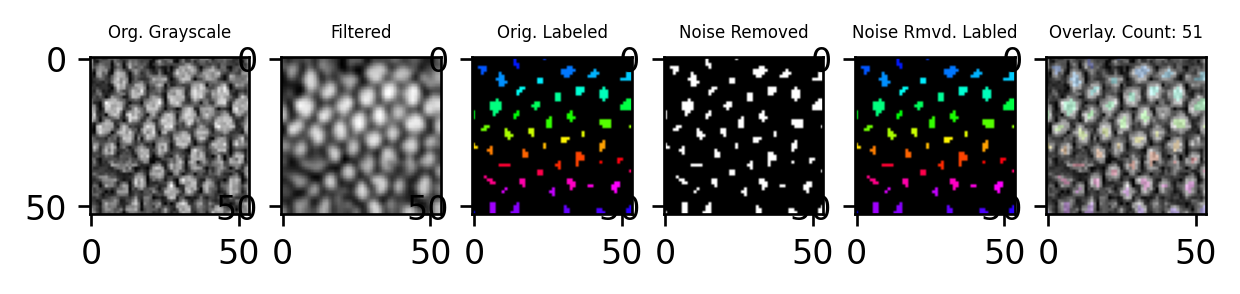

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 0.8624702558001189
Avg fullness: 0.4047512326311071

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: False


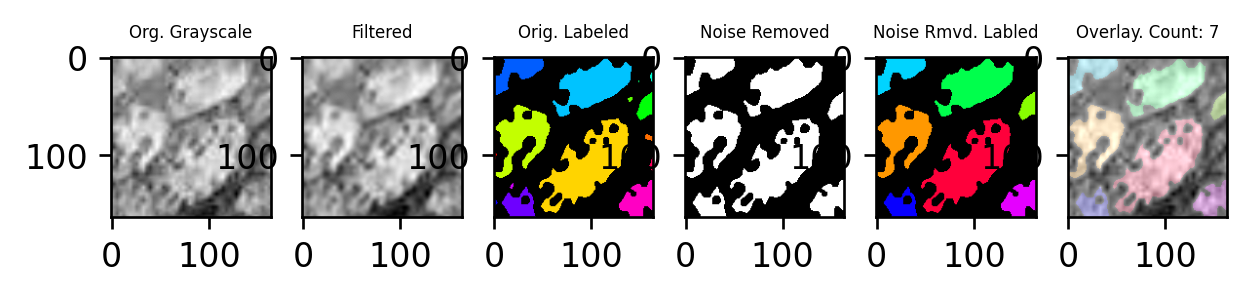

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 0.5465551900584795
Avg fullness: 0.6287089013632718

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: True
Scales shapes are full, not web-like: False


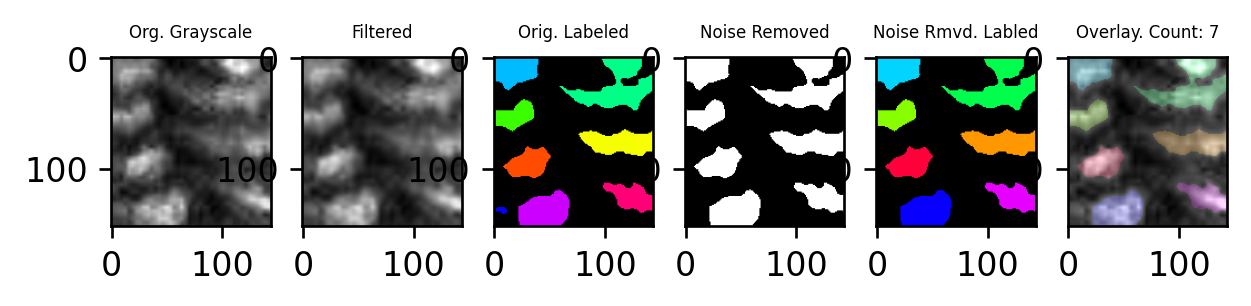

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Std dev for scale area: 29.765752132274432
(Std dev / mean) for scale area: 0.47816469288794267
Avg bounding box overlap: 0.3630952380952381
Avg fullness: 0.41408761803498645

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


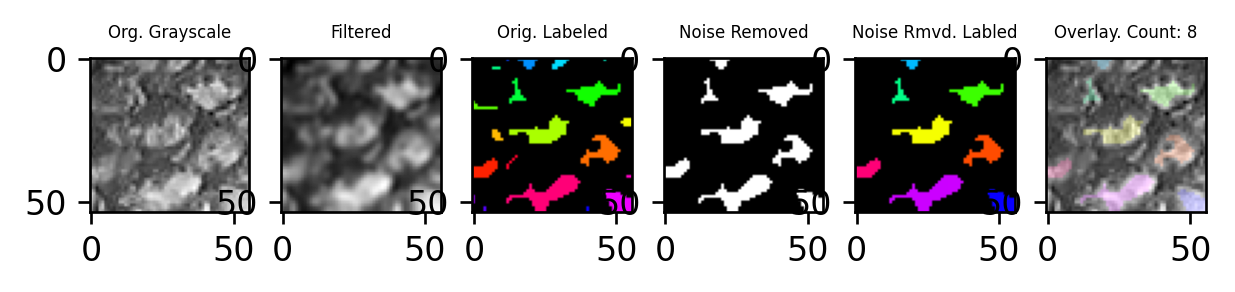

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Avg bounding box overlap: 0.4117063492063492
Avg fullness: 0.7857142857142857

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: True
Scales shapes are full, not web-like: True


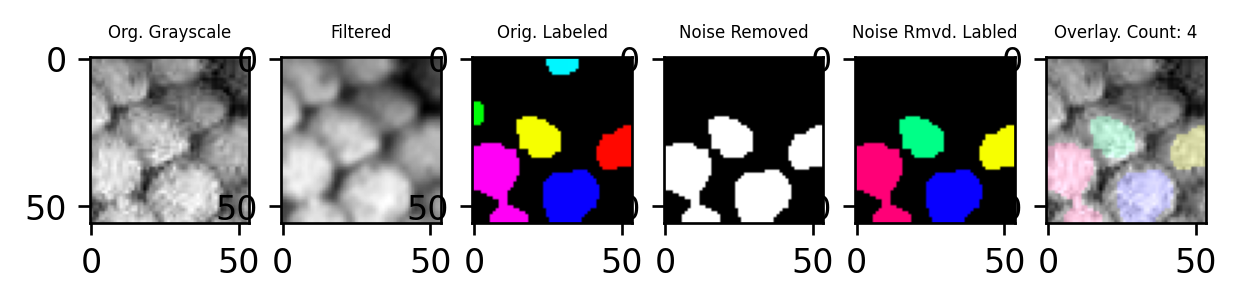

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 0.7143591772151898

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: Cannot determine because all scales are edge-scales


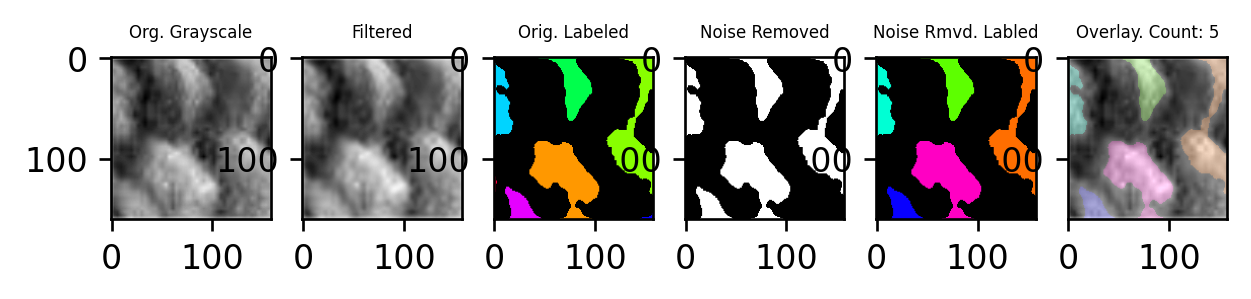

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 40.29888335921977
(Std dev / mean) for scale area: 0.31360998723128225
Avg bounding box overlap: 0.37207792207792206
Avg fullness: 0.5295775652918511

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


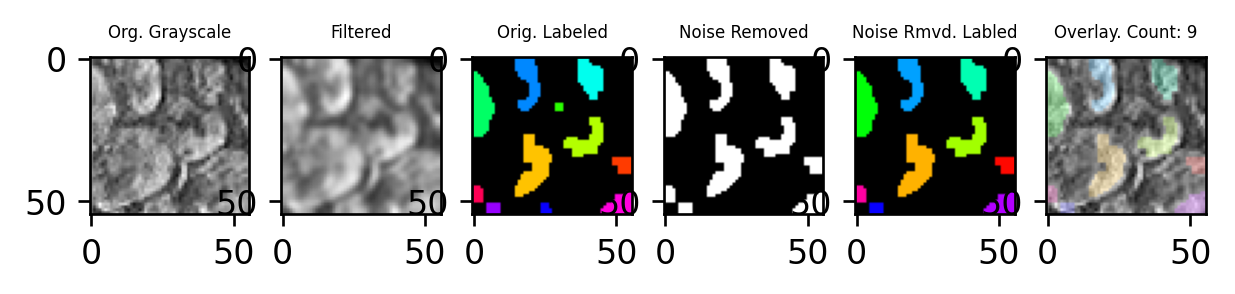

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Avg bounding box overlap: 0.4496527777777778
Avg fullness: 0.47692307692307695

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: True
Scales shapes are full, not web-like: False


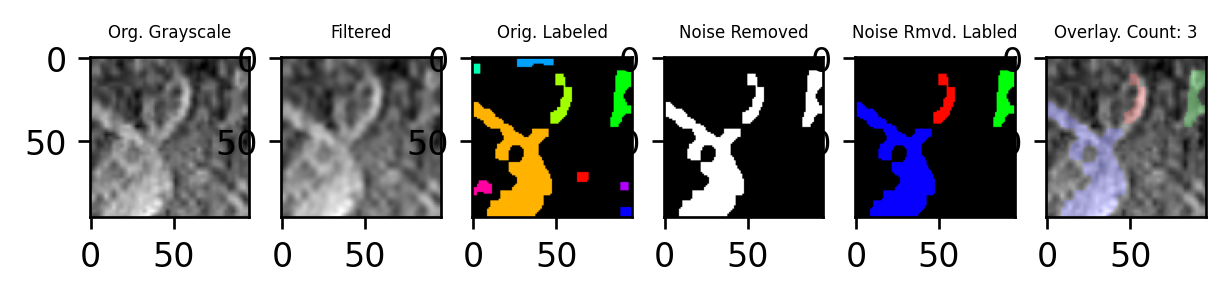

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 0.8307938740428192
Avg fullness: 0.43457627118644065

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: False


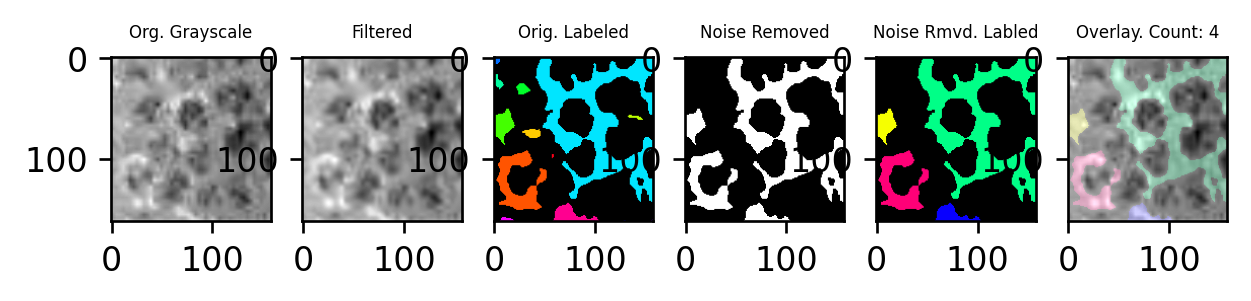

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
Std dev for scale area: 189.3964096808596
(Std dev / mean) for scale area: 0.9024248227795573
Avg bounding box overlap: 0.3487341772151899
Avg fullness: 0.6643943377661865

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: True
Scales are localized: True
Scales shapes are full, not web-like: False


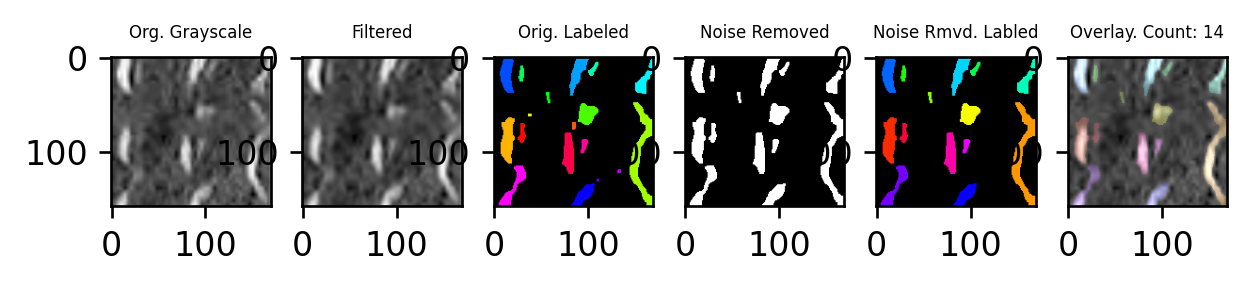

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85
Avg bounding box overlap: 0.9625

------------------------------------------------------
 OVERALL ANALYSIS
Scales are similar in size: Cannot determine because less than two non-edge scales
Scales are localized: False
Scales shapes are full, not web-like: Cannot determine because all scales are edge-scales


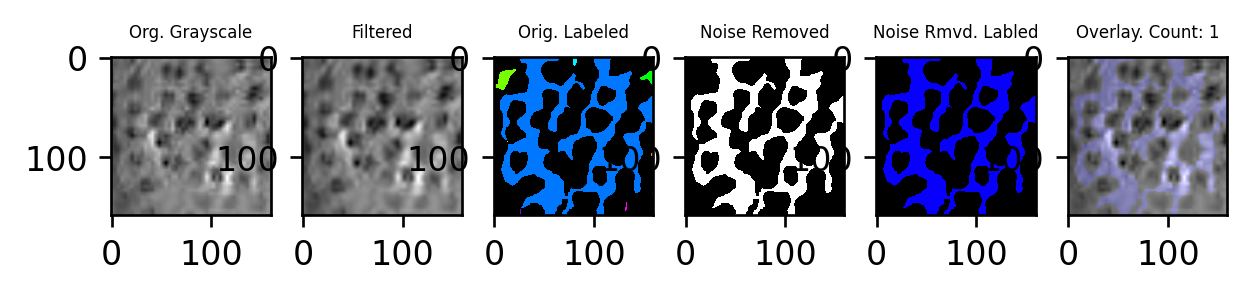

In [96]:
without_r = []
print("TRYING TO CLEAN UP THE IMAGES AND REMOVE SMALL SPECKELS: SHOULD TAKE INTO ACCOUNT DISTANCE AND SIZE")

index = 0;
for img in images:
    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # or whatever you prefer
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
    stats = output[2]


    kernel = np.ones((3,3),np.uint8)
    #opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    #closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 1)

    
    #review: what exactly does this do?
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < (averages[index]/10):
            img = cv2.drawContours(img, [c], -1, (0,0,0), -1)
    
    print(block_size[index][0])
    plt.subplot(1,6,1), plt.imshow(original_img[index], 'gray')
    plt.title("Org. Grayscale", fontsize=5)
    plt.subplot(1,6,2), plt.imshow(filter_img[index], 'gray')
    plt.title("Filtered", fontsize=5)
    plt.subplot(1,6,3), plt.imshow(labeled_imgs[index], 'gray')
    plt.title("Orig. Labeled", fontsize=5)
    plt.subplot(1,6,4), plt.imshow(img, 'gray')
    plt.title("Noise Removed", fontsize=5)
    
    analyze_results(img) # Calls the new function underneath the scale images


    # Label and count (taken from maggie's code)
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    count, labels = cv2.connectedComponents(img)                
    count = count - 1 # background doesn't count as a scale
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    without_r.append(labeled_img)

    plt.subplot(1, 6, 5), plt.imshow(labeled_img, 'gray')
    plt.title("Noise Rmvd. Labled", fontsize=5)
    plt.subplot(1, 6, 6), plt.imshow(overlay(original_img[index], labeled_img))
    plt.title("Overlay. Count: " + str(count), fontsize=5)



    plt.show()
    index = index + 1


In [95]:
# Maggie added (Analysis of results) -------------------------

def analyze_results(img):
    output = cv2.connectedComponentsWithStats(img, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    size_var = scale_size_variation(num_labels, stats, len(img), len(img[0]))
    localization = scale_localization(num_labels, stats, len(img), len(img[0]))
    full = scale_fullness(num_labels, stats, len(img), len(img[0]))
    
    if size_var == None:
        size_var = "Cannot determine because less than two non-edge scales"
    if full == None:
        full = "Cannot determine because all scales are edge-scales"
    
    print("\n------------------------------------------------------\n OVERALL ANALYSIS")
    print("Scales are similar in size: " + str(size_var))
    print("Scales are localized: " + str(localization))
    print("Scales shapes are full, not web-like: " + str(full))

    
def bounding_box_edges(i, stats):
     # find edges of bounding box
        left = stats[i, cv2.CC_STAT_LEFT]
        right = left + stats[i, cv2.CC_STAT_WIDTH] - 1
        top = stats[i, cv2.CC_STAT_TOP]
        bottom = top + stats[i, cv2.CC_STAT_HEIGHT] - 1
        return left, right, top, bottom
        
def scale_size_variation(num_labels, stats, img_len, img_width):
    scale_areas = []
    for i in range(1, num_labels): # start at 1 to ignore background
        
        left, right, top, bottom = bounding_box_edges(i, stats)
        # don't consider scales that touch the edge
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            continue
            
        scale_areas.append(stats[i, cv2.CC_STAT_AREA].astype(int))

    if len(scale_areas) > 1:
        stddev = statistics.stdev(scale_areas)
        mean = sum(scale_areas) / len(scale_areas)
        print("Std dev for scale area: " + str(stddev))
        print("(Std dev / mean) for scale area: " + str(stddev / mean))
       
        return (stddev / mean) < 1
        
        #box_areas = [(stats[i, cv2.CC_STAT_WIDTH] * stats[i, cv2.CC_STAT_HEIGHT]).astype(int) for i in range (1, num_labels)]
        #print(statistics.stdev(box_areas))
        
def scale_localization(num_labels, stats, img_len, img_width):
    #check for overlappingness of bounding boxes
    overlap_array = np.zeros((img_len, img_width))
    for i in range(1, num_labels): # start at 1 to ignore background
        left, right, top, bottom = bounding_box_edges(i, stats)
        for r in range(top, bottom + 1):
            for c in range(left, right + 1):
                overlap_array[r, c] += 1
    avg_overlap = np.average(overlap_array)
    print("Avg bounding box overlap: " + str(avg_overlap))
    percent_overlap = np.count_nonzero(overlap_array > 1) / np.size(overlap_array)
    
    return avg_overlap < 0.63
    
def scale_fullness(num_labels, stats, img_len, img_width):
    # squareness doesn't seem to be a good indication of roundness
    
    #squareness = []
    fullness = []
    for i in range(1, num_labels):
        
        left, right, top, bottom = bounding_box_edges(i, stats)
        # don't consider scales that touch the edge
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            continue
            
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        #squareness.append(min(w, h) / max(w, h)) # closer to 1 means more square, smaller than 1 means less square
        
        scale_area = stats[i, cv2.CC_STAT_AREA]
        box_area = w * h
        fullness.append(scale_area / box_area)
    #if squareness:
        #print("Avg squareness: " + str(sum(squareness) / len(squareness)))
    if fullness:
        avg_fullness = sum(fullness) / len(fullness)
        print("Avg fullness: " + str(avg_fullness))
    
        return avg_fullness > 0.7
        

# NOT USED
def comp_elipse_area(img):
    output = cv2.connectedComponentsWithStats(img, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    ratios = []
    for i in range(1, num_labels): # start at 1 to ignore background
        a = stats[i, cv2.CC_STAT_WIDTH] / 2
        b = stats[i, cv2.CC_STAT_HEIGHT] / 2
        elipse_area = 22/7 * a * b
        scale_area = stats[i, cv2.CC_STAT_AREA]
        area_ratio = scale_area / elipse_area
        ratios.append(area_ratio)
    roundness = sum(ratios) / (num_labels - 1)
    print(roundness)
    if (roundness < 0.59):
        print("INVERTED")